In [2]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.lines as pltl
import operator

In [3]:
df = pd.read_csv('apa_general_cuts_antimisprime.csv',sep=',')

print(len(df))
print(df.head())

cut_distribution = spio.loadmat('apa_general_cuts_antimisprime_orig_cutdistribution.mat')['cuts']
cut_distribution = sp.csr_matrix(cut_distribution)

3411338
                                                 seq  \
0  CTGCTTGTTAAGAACAAGTTTGGCTAAGCTGGCTAAAGTGGTAGGC...   
1  CTGCTTGTTAAGAACAAGTTTGGCTATGCTTTCGACGCTGTGGAGC...   
2  CTGCTAGCTGCTCACTGAATGCAGCCTGGTAACTGACCTTCAAAGC...   
3  CTGCTTGTTAAGAACAAGTTTGGCTGGTGACGCATTCGTCGACCTC...   
4  CTGCTTGTTAAGAACAAGTTTGGCTTTTAAACGGGGTTCCATTCTC...   

                                             seq_ext  total_count  library  \
0  GCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGGACTGAT...           12        5   
1  GCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGGACTGAT...           12        5   
2  GCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGGACTGAT...           12        8   
3  GCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGGACTGAT...           12       11   
4  GCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGGACTGAT...           12       11   

              library_name  
0  TOMM5_UPWT20N20_DN_WT20  
1  TOMM5_UPWT20N20_DN_WT20  
2   TOMM5_UPN20WT20_DN_N20  
3   TOMM5_UPWT20N20_DN_N20  
4   TOMM5_UPWT20N20_DN_N20  


In [4]:
bases = "ACGT"

mer2 = []
mer2_dict = {}
mer2_i = 0
mer4 = []
mer4_dict = {}
mer4_i = 0
mer6 = []
mer6_dict = {}
mer6_i = 0
for base1 in bases:
    for base2 in bases:
        mer2.append(base1 + base2)
        mer2_dict[base1 + base2] = mer2_i
        mer2_i += 1
        for base3 in bases:
            for base4 in bases:
                mer4.append(base1 + base2 + base3 + base4)
                mer4_dict[base1 + base2 + base3 + base4] = mer4_i
                mer4_i += 1
                for base5 in bases:
                    for base6 in bases:
                        mer6.append(base1 + base2 + base3 + base4 + base5 + base6)
                        mer6_dict[base1 + base2 + base3 + base4 + base5 + base6] = mer6_i
                        mer6_i += 1


In [5]:
#Filter data

data = df.copy()
cuts = cut_distribution.copy()


lib_index = np.nonzero((data.library_name == 'Simple') & (data.total_count >= 20))[0]

data = data.ix[(data.library_name == 'Simple') & (data.total_count >= 20)]

cuts = cuts[lib_index, :]

print(len(data))
print(cuts.shape)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':


505084
(505084, 186)


In [6]:
#Get vectors of target values

c = np.ravel(np.array(list(data.total_count)))
print(c)

[  20   20   20 ..., 1102 1174 1265]


In [7]:

#Pre-compute 6-mer feature matrices

def generate_mer_cutdict(seq_list, mer_list, mer_dict, c, cuts_dense, cuts_row) :
    mer_cut_dict = {}
    mer_count_dict = {}
    for mer in mer_list :
        mer_cut_dict[mer] = []
        mer_count_dict[mer] = 0
        
    total_cut = 0
    
    n_mer_length = len(mer_list[0])

    for i in range(0, len(seq_list)):
        if i % 1000000 == 0:
            print("Read up to sequence: " + str(i))
        
        #if i > 10000 :
        #    break
        
        seq = seq_list[i]
        
        if cuts_row[i] <= 0.5 or cuts_row[i] > 1.0 or np.isinf(cuts_row[i]) or np.isnan(cuts_row[i]) :
            continue
        
        for j in range(0, len(seq)-(n_mer_length-1)):
            motif = seq[j:j+n_mer_length]
            if motif in mer_dict :
                
                cut_prob = cuts_dense[i, j] / cuts_row[i]
                
                mer_cut_dict[motif].append(cut_prob * float(c[i]))

                total_cut += cut_prob * float(c[i])

                mer_count_dict[motif] += 1.0 * float(c[i])
                
                    
                
    for mer in mer_list :
        mer_cut_dict[mer] = np.ravel(np.array(mer_cut_dict[mer]))
    
    return mer_cut_dict, mer_count_dict, total_cut


#Cut region
seq_list = (data.seq.str.slice(60, 85)).values

cuts_dense = np.array(cuts.todense())[:, 60 : 85 - 1]
cuts_row = np.ravel(np.sum(cuts_dense, axis=1))
mer2_cut_dict, mer2_count_dict, total_cut = generate_mer_cutdict(seq_list, mer2, mer2_dict, c, cuts_dense, cuts_row)

mer2_cutprob_dict = {}
for mer in mer2 :
    mer2_cutprob_dict[mer] = np.sum(mer2_cut_dict[mer]) / mer2_count_dict[mer]


cuts_dense = np.array(cuts.todense())[:, 60 + 1 : 85 + 1 - 3]
cuts_row = np.ravel(np.sum(cuts_dense, axis=1))
mer4_cut_dict, mer4_count_dict, total_cut = generate_mer_cutdict(seq_list, mer4, mer4_dict, c, cuts_dense, cuts_row)

mer4_cutprob_dict = {}
for mer in mer4 :
    mer4_cutprob_dict[mer] = np.sum(mer4_cut_dict[mer]) / mer4_count_dict[mer]


cuts_dense = np.array(cuts.todense())[:, 60 + 2 : 85 + 2 - 5]
cuts_row = np.ravel(np.sum(cuts_dense, axis=1))
mer6_cut_dict, mer6_count_dict, total_cut = generate_mer_cutdict(seq_list, mer6, mer6_dict, c, cuts_dense, cuts_row)

mer6_cutprob_dict = {}
for mer in mer6 :
    mer6_cutprob_dict[mer] = np.sum(mer6_cut_dict[mer]) / mer6_count_dict[mer]

sorted_dict = sorted(mer6_cutprob_dict.items(), key=operator.itemgetter(1))
print(sorted_dict)

Read up to sequence: 0
Read up to sequence: 0
Read up to sequence: 0
[('AAAGTA', 0.0044947616525803126), ('AAAGCA', 0.0045314668810297939), ('AAACCT', 0.0048409031919277069), ('AAACCA', 0.0048446992858909507), ('AAAGGA', 0.0048497685796244916), ('AAACTA', 0.0048931797116970304), ('AAAGTT', 0.0049526771697676582), ('AAATTA', 0.005255777281716674), ('AAAAGG', 0.0052979183986247144), ('AAATCA', 0.0053187148363545564), ('AAACTT', 0.0053382748613882806), ('AAACTC', 0.0054014764681160994), ('AAATGT', 0.005465393453494412), ('AAATGA', 0.0054724485826451374), ('AAATTT', 0.0054732913993886115), ('AAAGTC', 0.0054782012818802408), ('AAAAGT', 0.005482970392579045), ('AAACGT', 0.0055221324787432481), ('AAAACA', 0.0055495663488110301), ('AAAGGC', 0.0055999992718899485), ('AAATCT', 0.0056414190523694837), ('AAAATA', 0.0056637581235524726), ('AAAATT', 0.0056823004628886436), ('AAAGCT', 0.0057387192884469258), ('AAAGCC', 0.0057642754619279092), ('AAAGGT', 0.0058166486056332439), ('AAACCC', 0.0058196726

In [11]:

#Plotting code for logodds ratio analysis

def plot_logodds_ratios(w, bootstrap, mer_list, mer_dict, fig_name) :
    n_mer_length = len(mer_list)
    
    highest_weight_index = np.argsort(w)[::-1]
    highest_weight_index_top = highest_weight_index[0:10]

    lowest_weight_index = np.argsort(w)
    lowest_weight_index_top = lowest_weight_index[0:10]

    w_sort_index = np.argsort(w)#[::-1]

    w_sorted = w[w_sort_index]
    mer_sorted = np.array(mer_list)[w_sort_index]
    bootstrap_sorted = bootstrap[:, w_sort_index]
    
    not_zero_index = np.nonzero(w_sorted != 0)[0]
    w_sorted = w_sorted[not_zero_index]
    mer_sorted = mer_sorted[not_zero_index]
    bootstrap_sorted = bootstrap_sorted[:, not_zero_index]
    n_mer_length = len(mer_sorted)
    
    f, axarr = plt.subplots(1, 2, figsize=(10, 10), sharex=False)#, sharey=True

    for i in range(0, n_mer_length) :
        axarr[0].plot([2*w_sorted[i] - bootstrap_sorted[0, i], 2*w_sorted[i] - bootstrap_sorted[1, i]], [i, i], color='black', alpha=1.0)

    axarr[0].scatter(w_sorted, np.arange(n_mer_length), color='purple', alpha=0.6, s=10)
    axarr[0].set_title('Logodds ratios of proximal selection')
    plt.sca(axarr[0])
    plt.axis([np.min(w_sorted), np.max(w_sorted), 0, n_mer_length])
    plt.yticks([], [])
    plt.xlabel('Logodds ratio')
    plt.ylabel('6-mers sorted on Logodds ratio')
    plt.tick_params(axis='x', which='major', labelsize=9)
    plt.tick_params(axis='x', which='minor', labelsize=7)
    plt.xticks(rotation=30)
    
    
    top_n = min(10, int(n_mer_length/2))
    
    w_sorted_top = np.concatenate([w_sorted[0:top_n], w_sorted[len(w_sorted) - top_n:]])
    mer_sorted_top = np.concatenate([mer_sorted[0:top_n], mer_sorted[len(mer_sorted) - top_n:]])
    bootstrap_sorted_top = np.concatenate([bootstrap_sorted[:, 0:top_n], bootstrap_sorted[:, bootstrap_sorted.shape[1] - top_n:]], axis=1)
    
    for i in range(0, 2 * top_n) :
        axarr[1].plot([2*w_sorted_top[i] - bootstrap_sorted_top[0, i], 2*w_sorted_top[i] - bootstrap_sorted_top[1, i]], [i, i], color='black', alpha=1.0)

    axarr[1].scatter(w_sorted_top, np.arange(2 * top_n), color='purple', alpha=0.7, s=10)
    axarr[1].plot([np.min(w_sorted_top), np.max(w_sorted_top)], [top_n - 0.25, top_n - 0.25], color='black', alpha=1.0)
    
    axarr[1].plot([np.min(w_sorted_top), np.max(w_sorted_top)], [top_n - 0.75, top_n - 0.75], color='black', alpha=1.0)
    axarr[1].set_title('Zoom-in view')
    axarr[1].yaxis.tick_right()
    plt.sca(axarr[1])
    plt.axis([np.min(w_sorted_top), np.max(w_sorted_top), -1, 2 * top_n])
    plt.yticks(np.arange(2 * top_n), mer_sorted_top.tolist(), color='purple')
    plt.xlabel('Logodds ratio')
    plt.tick_params(axis='x', which='major', labelsize=9)
    plt.tick_params(axis='x', which='minor', labelsize=7)
    plt.xticks(rotation=30)
    
    
    f.tight_layout()

    plt.subplots_adjust(top=0.85, wspace = 0.4)

    transFigure = f.transFigure.inverted()

    top_1_all = transFigure.transform(axarr[0].transData.transform([w_sorted[n_mer_length - top_n], n_mer_length - top_n]))
    top_n_all = transFigure.transform(axarr[0].transData.transform([w_sorted[n_mer_length - 1], n_mer_length - 1]))
    bottom_1_all = transFigure.transform(axarr[0].transData.transform([w_sorted[0], 0]))
    bottom_n_all = transFigure.transform(axarr[0].transData.transform([w_sorted[top_n - 1], top_n - 1]))

    top_1_zoom = transFigure.transform(axarr[1].transData.transform([w_sorted_top[top_n], top_n]))
    top_n_zoom = transFigure.transform(axarr[1].transData.transform([w_sorted_top[2 * top_n - 1], 2 * top_n - 1]))
    bottom_1_zoom = transFigure.transform(axarr[1].transData.transform([w_sorted_top[0], 0]))
    bottom_n_zoom = transFigure.transform(axarr[1].transData.transform([w_sorted_top[top_n - 1], top_n - 1]))

    line_top_1 = pltl.Line2D((top_1_all[0],top_1_zoom[0]),(top_1_all[1],top_1_zoom[1]), transform=f.transFigure, color='black', linestyle='dashed')
    line_top_n = pltl.Line2D((top_n_all[0],top_n_zoom[0]),(top_n_all[1],top_n_zoom[1]), transform=f.transFigure, color='black', linestyle='dashed')
    line_bottom_1 = pltl.Line2D((bottom_1_all[0],bottom_1_zoom[0]),(bottom_1_all[1],bottom_1_zoom[1]), transform=f.transFigure, color='black', linestyle='dashed')
    line_bottom_n = pltl.Line2D((bottom_n_all[0],bottom_n_zoom[0]),(bottom_n_all[1],bottom_n_zoom[1]), transform=f.transFigure, color='black', linestyle='dashed')

    f.lines = line_top_1, line_top_n, line_bottom_1, line_bottom_n

    #f.suptitle(n_mer + ' Logodds ratios for Sublibrary: ' + lib_name, fontsize=14)

    plt.savefig(fig_name + ".svg")
    plt.show()
    plt.close()



In [9]:

#Logodds ratio analysis

def get_logodds_ratios(mer_list, mer_cutprob_dict, mer_cut_dict, mer_count_dict) :
    logodds_ratios = np.zeros(len(mer_cutprob_dict))

    for i in range(0, len(mer_list)) :
        mer = mer_list[i]

        avg_with = mer_cutprob_dict[mer]
        
        avg_without = 0
        norm = 0
        for j in range(0, len(mer_list)) :
            if i == j :
                continue
            avg_without += mer_cutprob_dict[mer_list[j]]
            norm += 1.0
        avg_without /= norm
        

        logodds_ratio = (avg_with / (1.0 - avg_with)) / (avg_without / (1.0 - avg_without))
        logodds_ratios[i] = np.log(logodds_ratio)
    
    #N-fold bootstrapping for confidence interval estimation
    n_bootstraps = 5#50
    alpha = 1.0 - 0.95
    
    #n = 0
    #for 

    '''bootstrapped_logodds_ratios = np.zeros((len(mer6_cut_dict), n_bootstraps))
    for k in range(0, n_bootstraps) :
        print('Performing bootstrap ' + str(k))

        bootstrap_index = np.random.choice(len(y), size=len(y))

        for i in range(X.shape[1]) :
            X_dim = np.ravel(X[:,i].todense())

            X_dim = X_dim[bootstrap_index]
            X_sum_boot = X_sum[bootstrap_index]


            with_index = np.nonzero((X_dim > 0) & (X_sum_boot > 0))
            without_index = np.nonzero((X_dim <= 0) & (X_sum_boot > 0))

            with_prox = y_boostrap[with_index]
            without_prox = y_boostrap[without_index]

            avg_with_prox = np.mean(with_prox)
            avg_without_prox = np.mean(without_prox)

            logodds_ratio = (avg_with_prox / (1.0 - avg_with_prox)) / (avg_without_prox / (1.0 - avg_without_prox))
            bootstrapped_logodds_ratios[i, k] = np.log(logodds_ratio)

    bootstrap_percentiles = np.percentile(bootstrapped_logodds_ratios, [100.0 * (1.0 - alpha/2.0), 100.0 * (alpha/2.0)], axis=1)
    '''
    bootstrap_percentiles = np.zeros((2, len(mer_list)))
    
    nan_index = np.nonzero(np.isinf(logodds_ratios) | np.isnan(logodds_ratios))[0]
    logodds_ratios[nan_index] = 0
    bootstrap_percentiles[:, nan_index] = 0

    nan_index = np.nonzero(np.isinf(bootstrap_percentiles) | np.isnan(bootstrap_percentiles))[1]
    logodds_ratios[nan_index] = 0
    bootstrap_percentiles[:, nan_index] = 0

    return logodds_ratios, bootstrap_percentiles


w_cut2, w_cut2_bootstrap = get_logodds_ratios(mer2, mer2_cutprob_dict, mer2_cut_dict, mer2_count_dict)
w_cut4, w_cut4_bootstrap = get_logodds_ratios(mer4, mer4_cutprob_dict, mer2_cut_dict, mer2_count_dict)
w_cut6, w_cut6_bootstrap = get_logodds_ratios(mer6, mer6_cutprob_dict, mer2_cut_dict, mer2_count_dict)


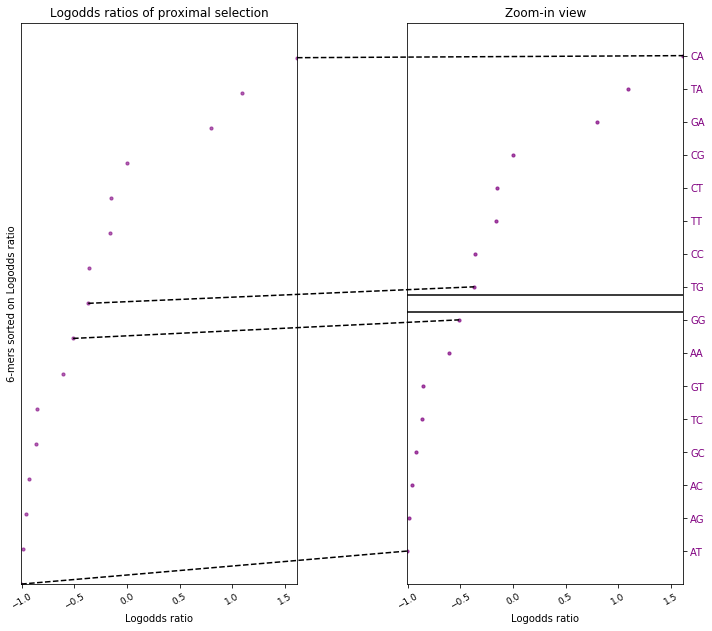

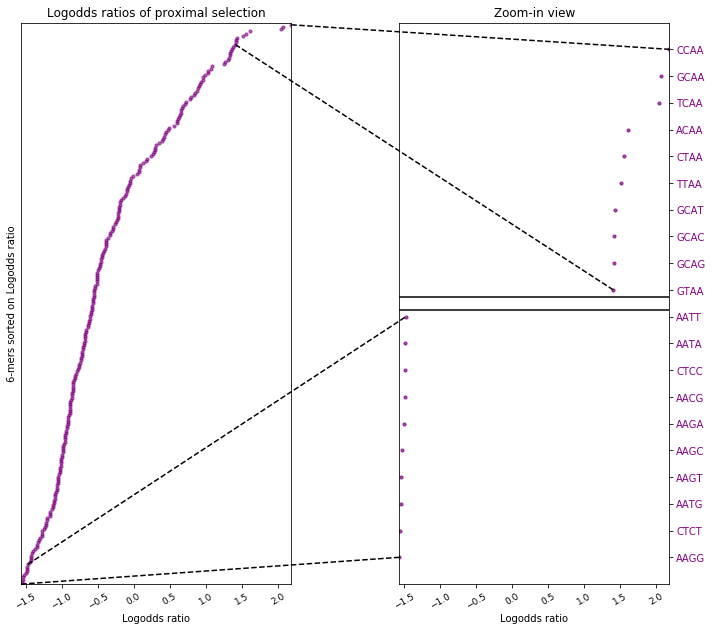

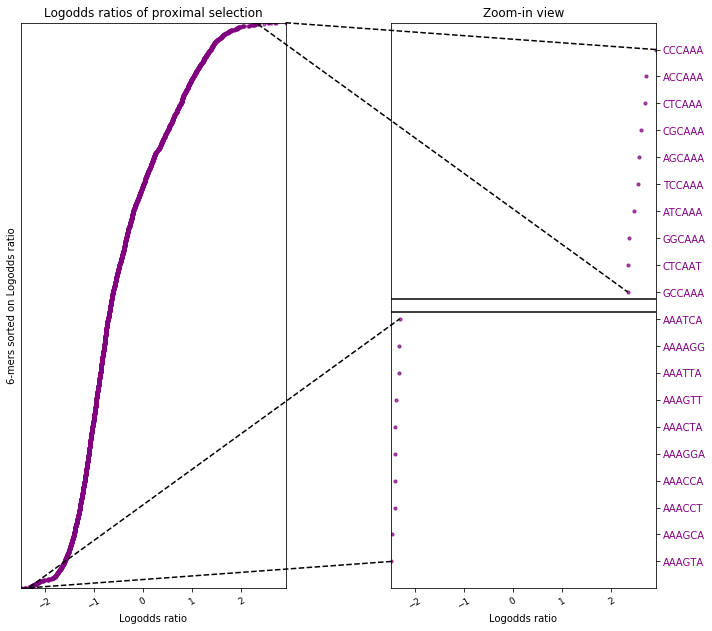

In [12]:

#Plot logodds ratios
plot_logodds_ratios(w_cut2, w_cut2_bootstrap, mer2, mer2_dict, 'simple_cutsite_2mer')

plot_logodds_ratios(w_cut4, w_cut4_bootstrap, mer4, mer4_dict, 'simple_cutsite_4mer')

plot_logodds_ratios(w_cut6, w_cut6_bootstrap, mer6, mer6_dict, 'simple_cutsite_6mer')